In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_string_dtype, is_numeric_dtype

In [32]:
df = pd.read_csv("Mall_Customers.csv")

In [33]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [34]:
df.shape

(200, 5)

### Examine the distribution of each field. Bar charts for categorical and histograms for numeric

In [35]:
#populate list of numerical and categorical variables
num_list = []
cat_list = []

for column in df:
    if is_numeric_dtype(df[column]):
        num_list.append(column)
    elif is_string_dtype(df[column]):
        cat_list.append(column)
        
print("numeric:", num_list)
print("categorical:", cat_list)

numeric: ['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)']
categorical: ['Gender']


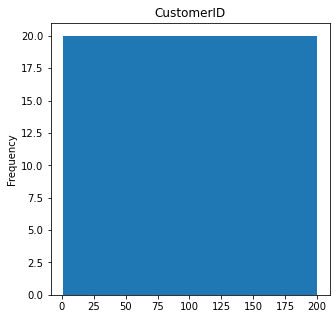

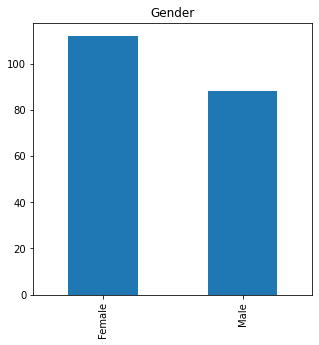

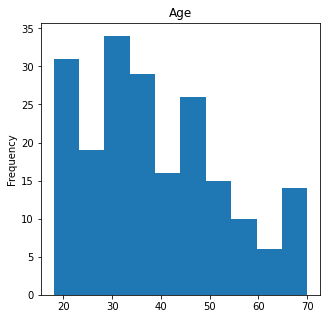

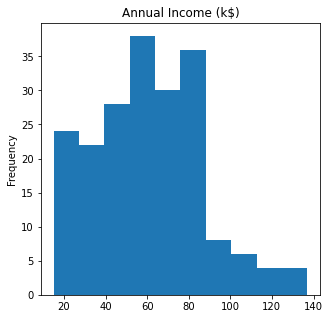

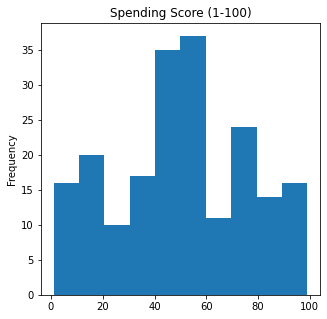

In [36]:
for column in df:
    plt.figure(column, figsize = (5,5))
    plt.title(column)
    if is_numeric_dtype(df[column]):
        df[column].plot(kind = 'hist')
    elif is_string_dtype(df[column]):
        df[column].value_counts()[:10].plot(kind = 'bar')

### Data Preprocessing

In [37]:
# Dropping customerid and gender from the df because we are using K-means clustering
df = df.drop(["CustomerID", "Gender"], axis = 1)

In [38]:
df.head()

,Age,Annual Income (k$),Spending Score (1-100)
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


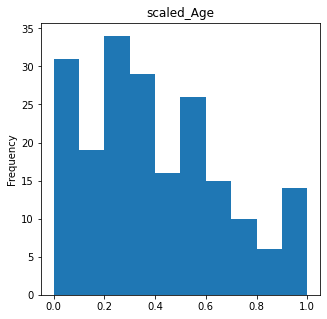

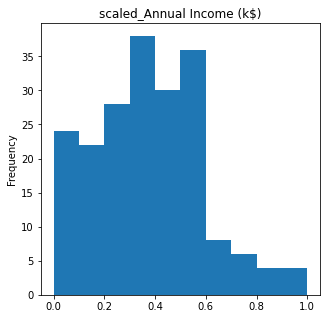

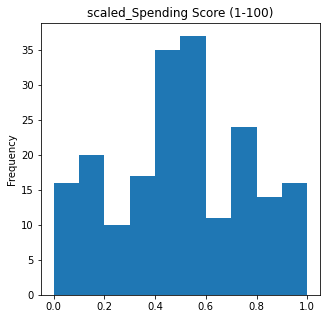

In [39]:
# Transform data in the standard scale
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

for var in ["Age", "Annual Income (k$)", "Spending Score (1-100)"]:
    scaled_var = "scaled_" + var 
    model = scaler.fit(df[var].values.reshape(-1,1))
    df[scaled_var] = model.transform(df[var].values.reshape(-1,1))
    
    plt.figure(figsize = (5,5))
    plt.title(scaled_var)
    df[scaled_var].plot(kind = 'hist')

EDA
Exploratory Data Analysis provides visual clues about whether it is likely to form insightful clusters when combining multiple variables together. It is also an imperative step because choosing an appropriate clustering algorithm is reliant on the shape of the cluster. Some center-based algorithms (e.g. K Means) are more adaptable towards globular shapes clusters and they tend to break linear shaped clusters apart. While density-based algorithms (e.g. DBSCAN) are better at clusters with irregular shape and a lot of noise.

I have visualized those three fields in the following way.

2D Scatter Plot

age vs. annual income
annual income vs. spending score
age vs. spending income


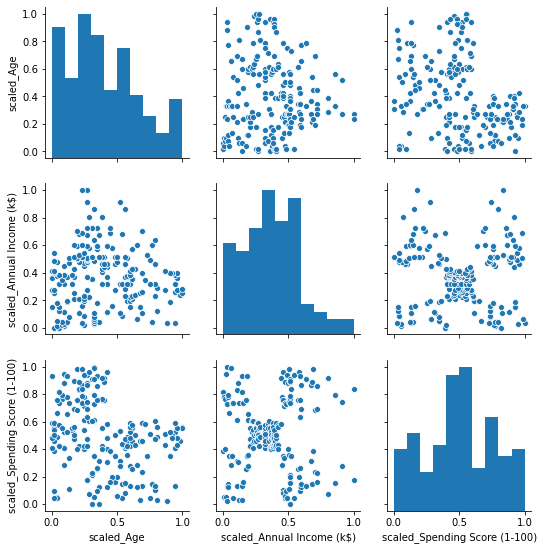

In [40]:
columns = ["scaled_Age", "scaled_Annual Income (k$)", "scaled_Spending Score (1-100)"]
sns.pairplot(df[columns])

### 3D Scatter Plot:

age vs. annual income vs. spending score

Text(0.5, 0, 'scaled_Spending Score (1-100)')

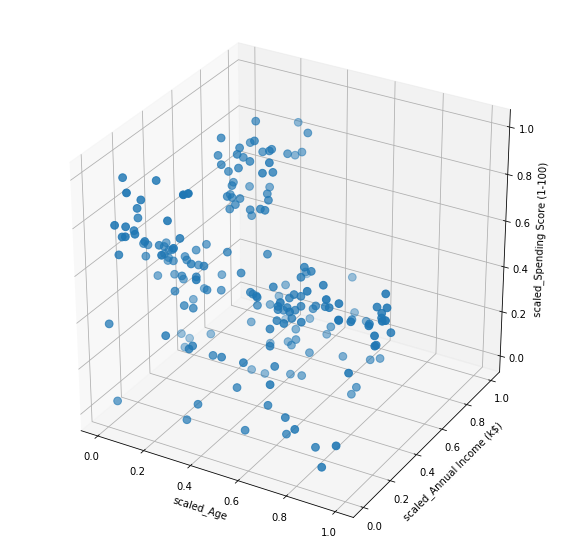

In [41]:
#3D Scatter Plot
from mpl_toolkits.mplot3d import Axes3D

axis_list = ["scaled_Age", "scaled_Annual Income (k$)", "scaled_Spending Score (1-100)"]
x, y, z = axis_list

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(projection = "3d")
sc = ax.scatter(df[x], df[y], df[z], s = 60)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)


### In this case, it is apparent that the plot of “annual income vs. spending score” generates some center-based clusters. Therefore, I will use K means algorithm for further exploration.

### K Means Clustering
#### How does K Means Clustering work?
K Means Clustering is a centre-based clustering algorithm, which means that it assigns data points to clusters based on closeness or distance, following these procedures:

- Specify the number of clusters “K”.
- Initiate K random centroids and assign each cluster a centroid: Centroid is the center of each cluster. There are k data points randomly selected as the centroids at the beginning, and the cluster label of other data points are later defined relatively to them. Consequently, different initial centroid assignments may lead to different cluster formations.
- Form K clusters by assigning data points to the closest centroid: The closest centroid is usually defined by the smallest Euclidean distance but it can also be correlation or cosine depends on the use cases.
- Recompute the centroid of each cluster : After all data points have been assigned to a cluster, for each cluster we recalculate the mean of all data points belonging to that cluster and define it as the new centroid.
- Reach convergence when centroids no longer change: Iterate step 2–4 until reaching the stoping criteria that either the centroids no longer change or the maximum number of iterations are reached.

In [42]:
# We are building the Kmeans using Sklearn
from sklearn.cluster import KMeans
from sklearn import metrics

def KMeans_Algorithm(dataset, n):
    clustering_KMeans = KMeans(n_clusters = n, init = 'k-means++', max_iter = 300, random_state = 0, algorithm = "elkan")
    clustering_KMeans.fit(dataset)
    
    # create data_frame to store centroids 
    centroids = clustering_KMeans.cluster_centers_
    centroids_df = pd.DataFrame(centroids, columns = ['X', 'Y'])
    
    #Add Cluster Label for each data point
    
    label  = clustering_KMeans.labels_
    df["label"] = label
    
    
    # Evaluation Metrics for clustering - Inertia and Silhouette Score
    
    inertia = clustering_KMeans.inertia_
    silhouette_score = metrics.silhouette_score(dataset, label)
    
    return inertia, label, centroids_df, silhouette_score
    
    
    

In [52]:
# Spending Score vs age
X1 = df[["scaled_Age", "scaled_Spending Score (1-100)"]].values

# Spending Score vs Annual Income
X2 = df[["scaled_Annual Income (k$)", "scaled_Spending Score (1-100)"]].values

# Spending Score vs Age vs Annual Income
X3 = df[["scaled_Age", "scaled_Annual Income (k$)", "scaled_Spending Score (1-100)"]].values

In [53]:
X3[0:4]

array([[0.01923077, 0.        , 0.3877551 ],
       [0.05769231, 0.        , 0.81632653],
       [0.03846154, 0.00819672, 0.05102041],
       [0.09615385, 0.00819672, 0.7755102 ]])

Text(0, 0.5, 'Silhouette Score')

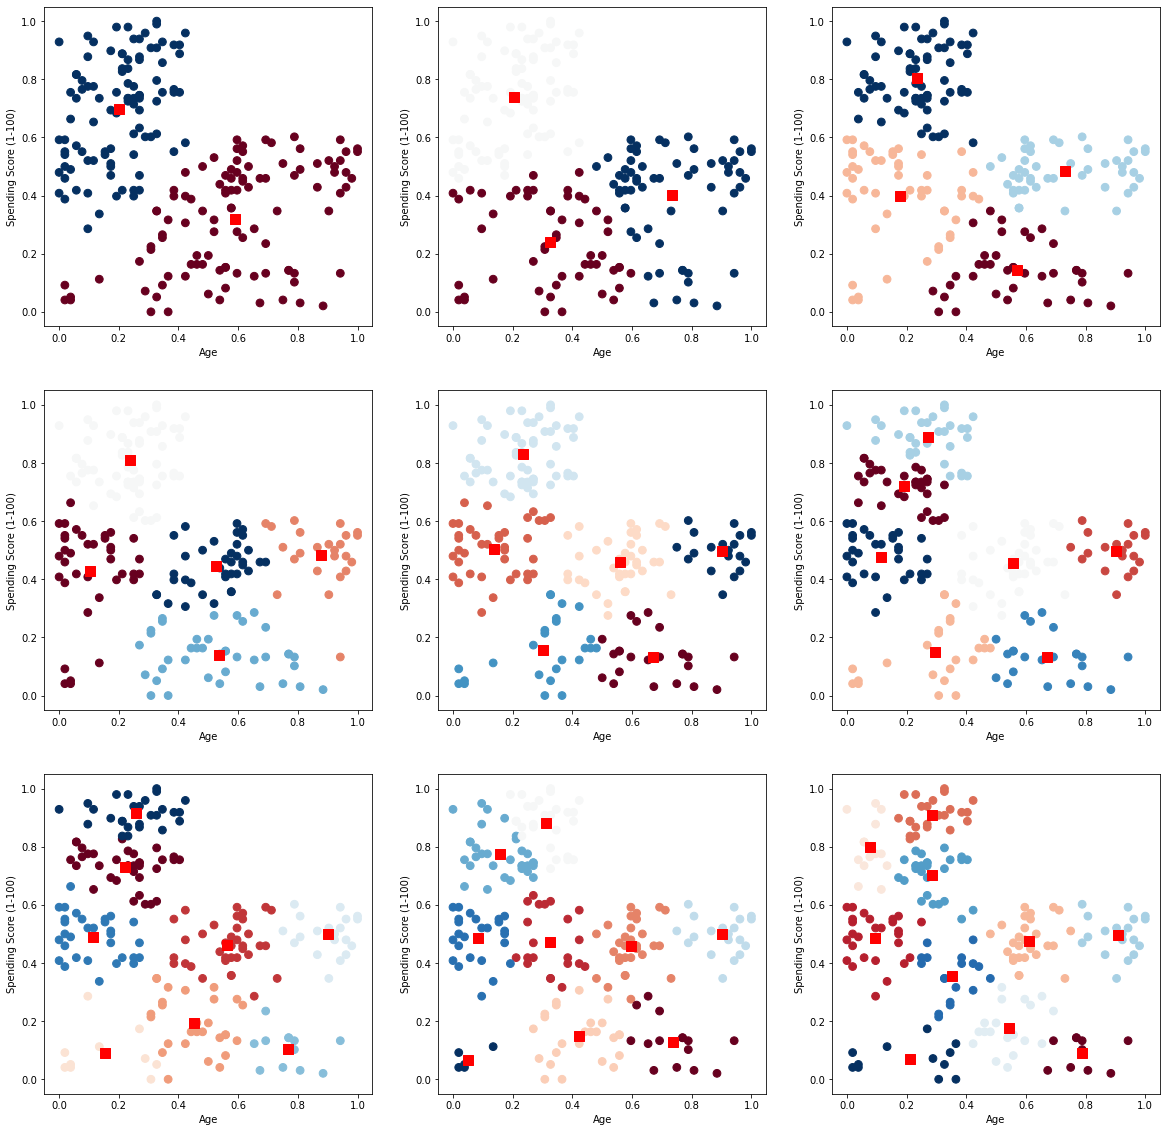

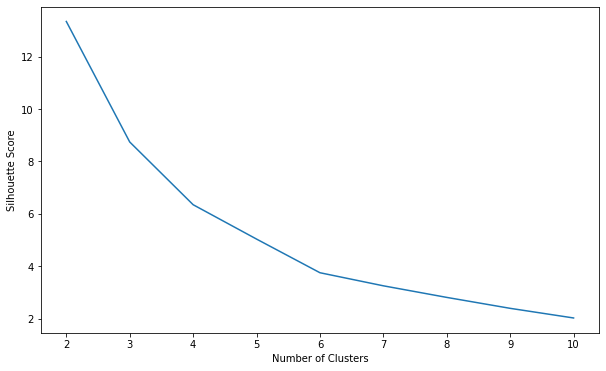

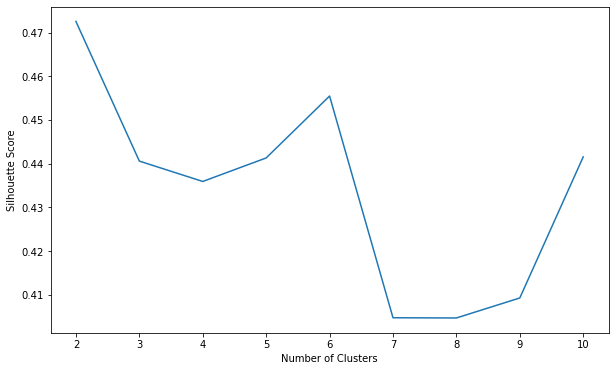

In [47]:
# Spending Score vs age by different number of clusters

X1_inertia_values = []
X1_silhouette_scores = []
fig1 = plt.figure(figsize=(20,20))

for i in range (2, 11):
    X1_inertia, X1_label, X1_centroids, X1_silhouette = KMeans_Algorithm(X1, i)
    X1_inertia_values.append(X1_inertia)
    X1_silhouette_scores.append(X1_silhouette)
    centroids_df = pd.DataFrame(X1_centroids, columns = ["X", "Y"])
    
    
    sub = fig1.add_subplot(330 + i -1)
    sub.scatter(df["scaled_Age"], df["scaled_Spending Score (1-100)"], s = 60, c = df["label"], cmap = "RdBu")
    sub.scatter(centroids_df["X"], centroids_df["Y"], s = 90, marker = ",", color = "r")
    sub.set_xlabel("Age")
    sub.set_ylabel("Spending Score (1-100)")
    

    
# Plot inertia Values agains number of clusters

plt.figure(figsize = (10, 6))
plt.plot(np.arange(2,11), X1_inertia_values)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

# Plot silhouette score agains number of clusters

plt.figure(figsize = (10, 6))
plt.plot(np.arange(2,11), X1_silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

### Annual Income vs Spending Score

Text(0, 0.5, 'Silhouette Score')

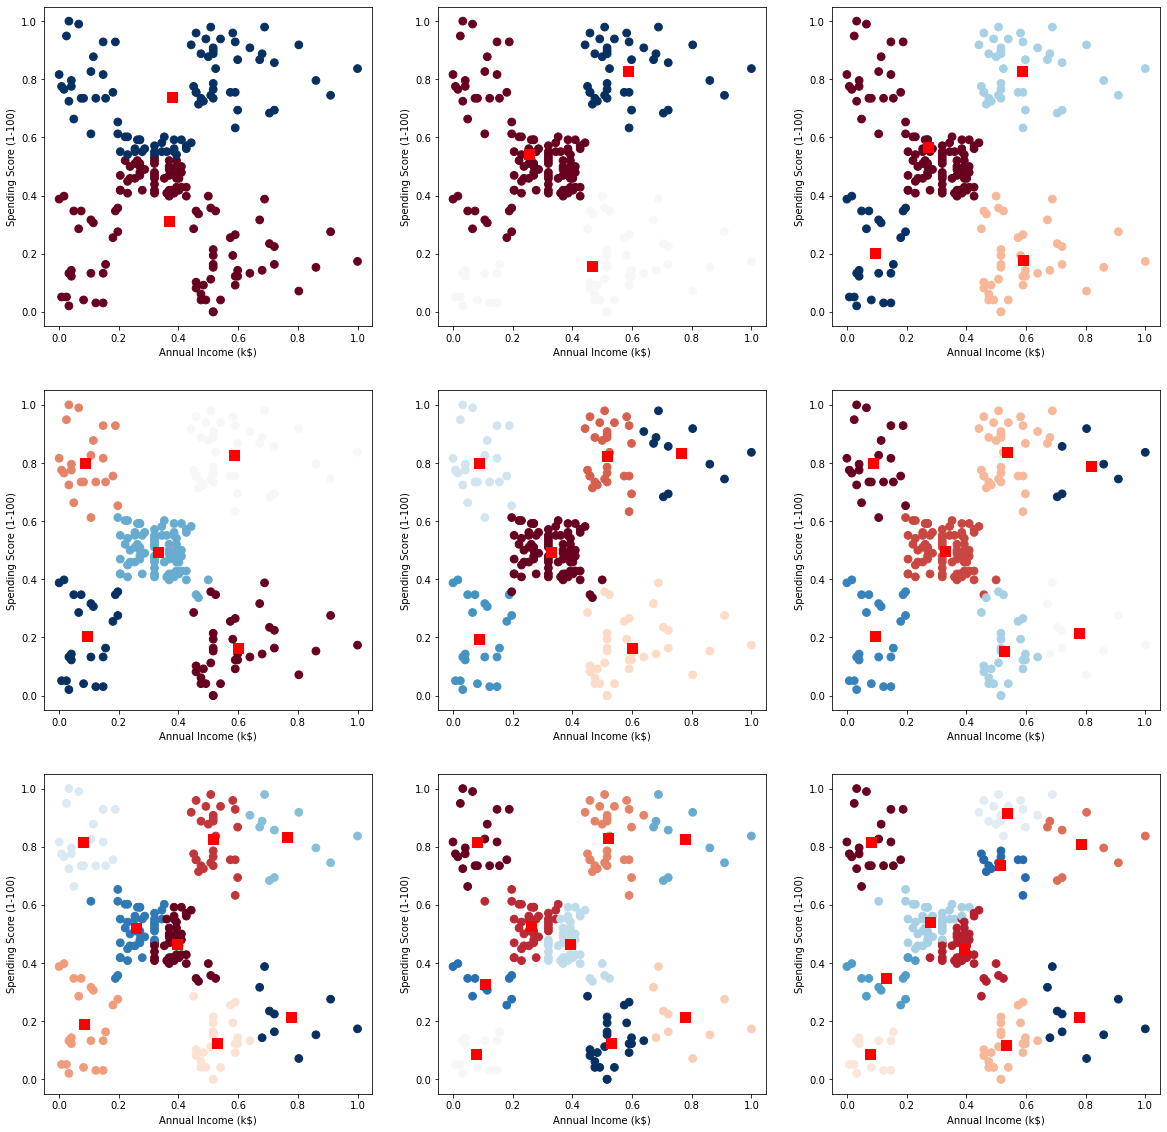

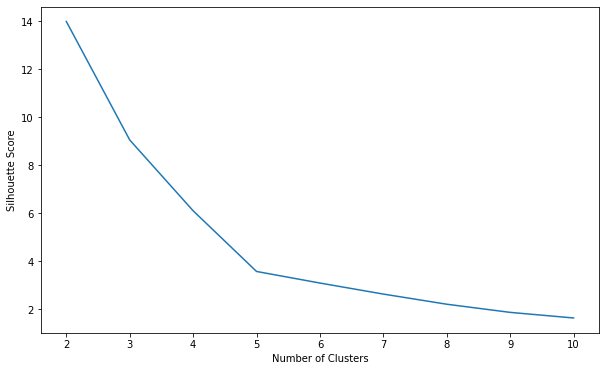

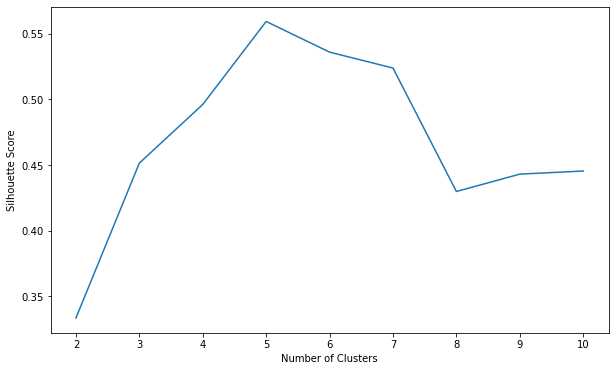

In [48]:
# Annual Income vs Spending Score by different number of clusters

X2_inertia_values = []
X2_silhouette_scores = []
fig2 = plt.figure(figsize=(20,20))

for i in range (2, 11):
    X2_inertia, X2_label, X2_centroids, X2_silhouette = KMeans_Algorithm(X2, i)
    X2_inertia_values.append(X2_inertia)
    X2_silhouette_scores.append(X2_silhouette)
    centroids_df = pd.DataFrame(X2_centroids, columns = ["X", "Y"])
    
    
    sub = fig2.add_subplot(330 + i -1)
    sub.scatter(df["scaled_Annual Income (k$)"], df["scaled_Spending Score (1-100)"], s = 60, c = df["label"], cmap = "RdBu")
    sub.scatter(centroids_df["X"], centroids_df["Y"], s = 90, marker = ",", color = "r")
    sub.set_xlabel("Annual Income (k$)")
    sub.set_ylabel("Spending Score (1-100)")
    

    
# Plot inertia Values agains number of clusters

plt.figure(figsize = (10, 6))
plt.plot(np.arange(2,11), X2_inertia_values)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

# Plot silhouette score agains number of clusters

plt.figure(figsize = (10, 6))
plt.plot(np.arange(2,11), X2_silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

In [63]:
def KMeans_Algorithm(dataset, n):
    clustering_KMeans = KMeans(n_clusters = n, init = 'k-means++', max_iter = 300, random_state = 0, algorithm = "elkan")
    clustering_KMeans.fit(dataset)
    
    # create data_frame to store centroids 
    centroids = clustering_KMeans.cluster_centers_
    centroids_df = pd.DataFrame(centroids, columns = ['X', 'Y', 'Z'])
    
    #Add Cluster Label for each data point
    
    label  = clustering_KMeans.labels_
    df["label"] = label
    
    
    # Evaluation Metrics for clustering - Inertia and Silhouette Score
    
    inertia = clustering_KMeans.inertia_
    silhouette_score = metrics.silhouette_score(dataset, label)
    
    return inertia, label, centroids_df, silhouette_score

### Annual Income vs Age vs Spending Score

Text(0, 0.5, 'Silhouette Score')

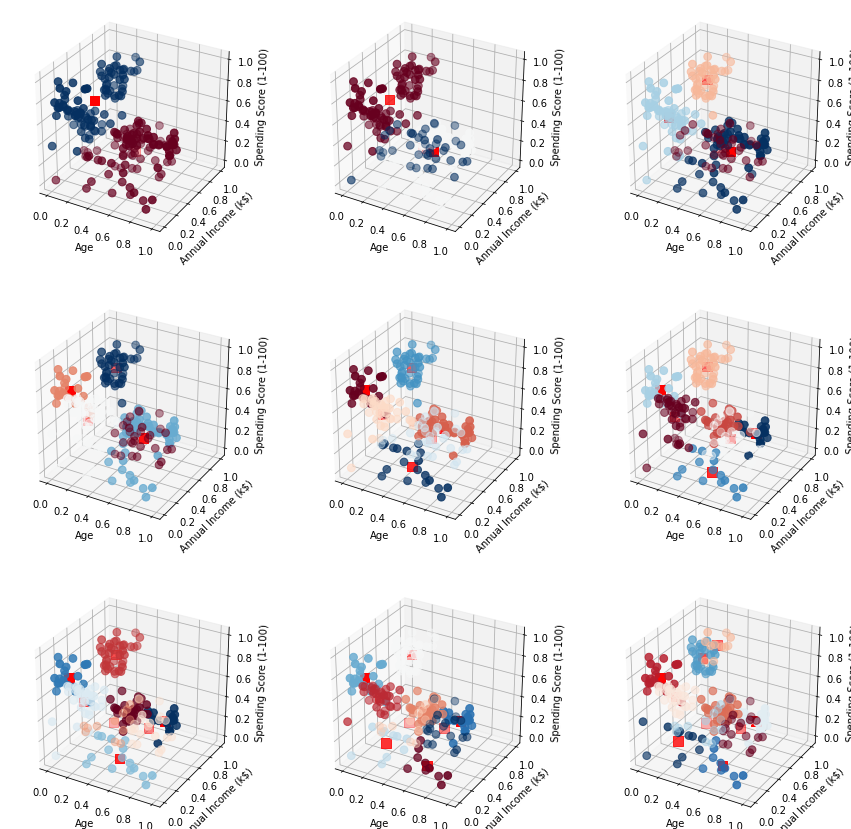

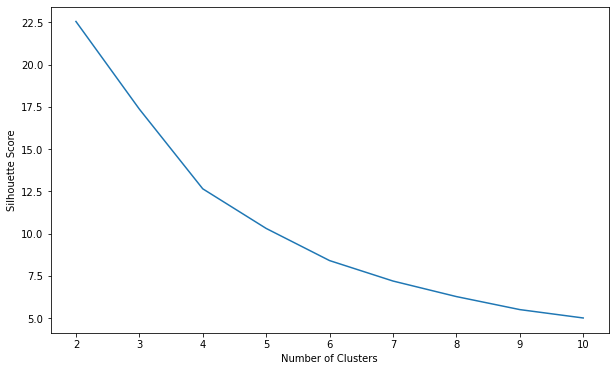

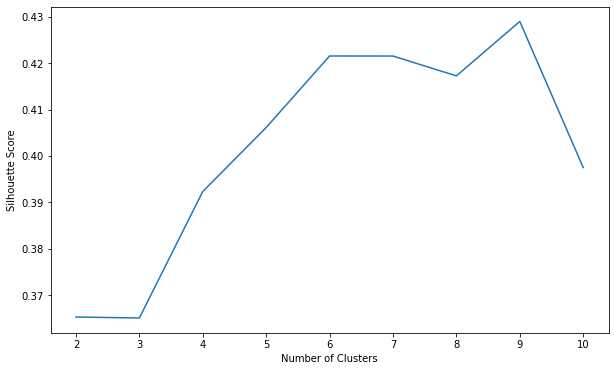

In [64]:
# Annual Income vs Age vs Spending Score by different number of clusters

X3_inertia_values = []
X3_silhouette_scores = []
fig = plt.figure(figsize=(15,15))

for i in range (2, 11):
    X3_inertia, X3_label, X3_centroids, X3_silhouette = KMeans_Algorithm(X3, i)
    X3_inertia_values.append(X3_inertia)
    X3_silhouette_scores.append(X3_silhouette)
    centroids_df = pd.DataFrame(X3_centroids, columns = ["X", "Y", "Z"])
    
    
    ax = fig.add_subplot(330 + i -1, projection ='3d')
    ax.scatter(df["scaled_Age"], df["scaled_Annual Income (k$)"], df["scaled_Spending Score (1-100)"], s = 60, c = df["label"], cmap = "RdBu")
    ax.scatter(centroids_df["X"], centroids_df["Y"], centroids_df["Z"], s = 90, marker = ",", color = "r")
    ax.set_xlabel("Age")
    ax.set_ylabel("Annual Income (k$)")
    ax.set_zlabel("Spending Score (1-100)")
    

    
# Plot inertia Values agains number of clusters

plt.figure(figsize = (10, 6))
plt.plot(np.arange(2,11), X3_inertia_values)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")

# Plot silhouette score agains number of clusters

plt.figure(figsize = (10, 6))
plt.plot(np.arange(2,11), X3_silhouette_scores)
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")